In [ ]:
!pip install librosa

In [1]:
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns

# Model 
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:\\Users\\OMOLP091\\Documents\\GitHub\\SOUND_DIRECTION_PROJECT\\sound_direction\\music-folder-dataset\\music_folder_dataset.csv')
audioPath = 'C:\\Users\\OMOLP091\\Documents\\GitHub\\SOUND_DIRECTION_PROJECT\\sound_direction\\music-folder-dataset'
data.head()

,slice_file_name,fsID,start,end,salience,music_folder,classID,class
0,Classical-Music_0.wav,Classical-Music_0,0,9.99,1,1,1,Classical-Music-Low
1,Classical-Music_1.wav,Classical-Music_1,0,9.99,1,1,1,Classical-Music-Low
2,Classical-Music_2.wav,Classical-Music_2,0,9.99,1,1,1,Classical-Music-Low
3,Classical-Music_3.wav,Classical-Music_3,0,9.99,1,1,1,Classical-Music-Low
4,Classical-Music_4.wav,Classical-Music_4,0,9.99,1,1,1,Classical-Music-Low


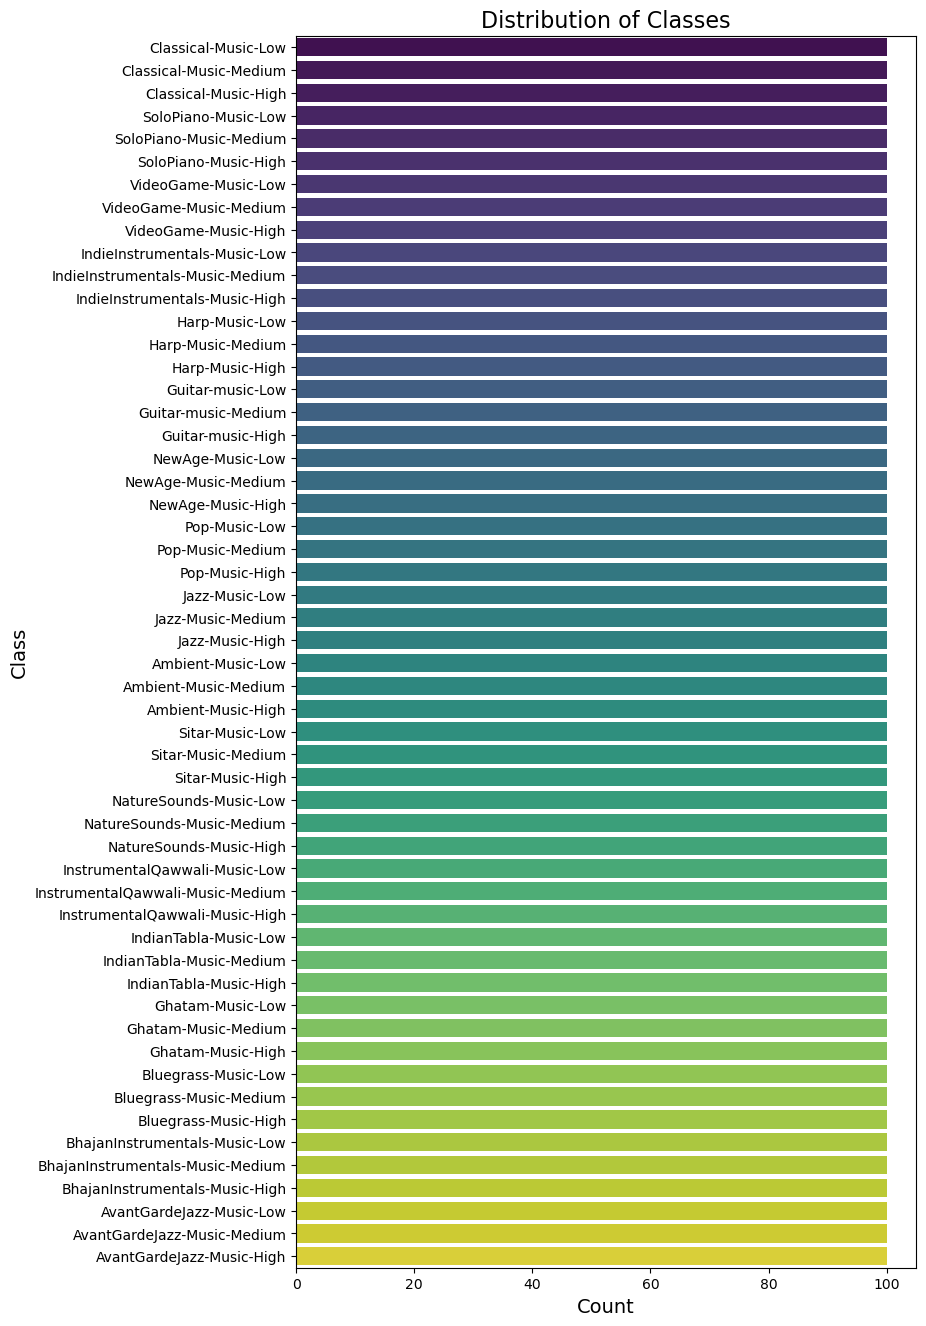

In [3]:
plt.figure(figsize = (8, 16))
sns.countplot(y = data['class'], palette = 'viridis')
plt.title('Distribution of Classes', fontsize = 16)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

Class : Guitar-music-High



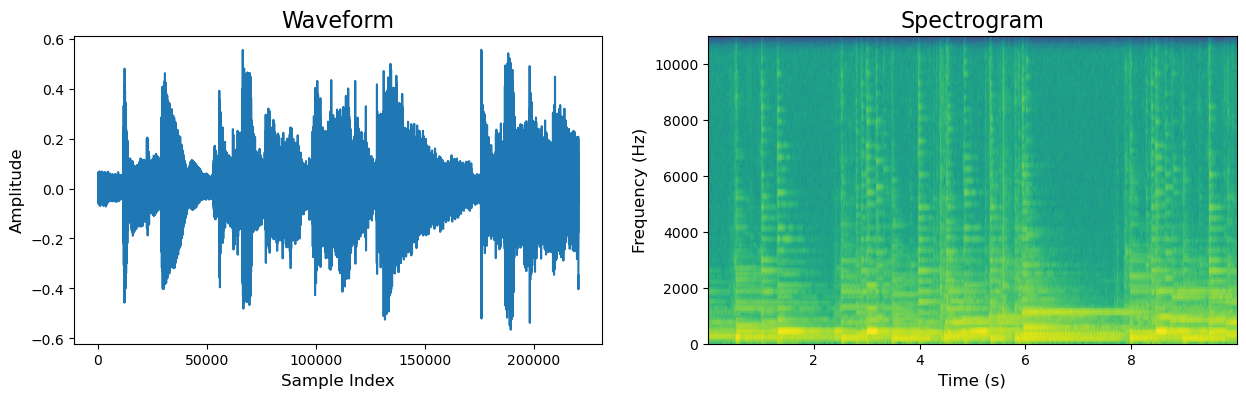

In [4]:
# Displaying a random waveform and spectrogram

# Randomly selecting a row
row = data.sample(1).iloc[0]

# Constructing file path
audioFile = os.path.join(audioPath, 'music_folder' + str(row['music_folder']), row['slice_file_name'])

# Loading audio file
waveform, sampleRate = librosa.load(audioFile)

# Displaying audio
print(f"Class : {row['class']}\n")
ipd.display(ipd.Audio(waveform, rate = sampleRate))

# Displaying waveform
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(waveform)
plt.title('Waveform', fontsize = 16)
plt.xlabel('Sample Index', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)

# Displaying spectrogram
plt.subplot(1, 2, 2)
plt.specgram(waveform, Fs = sampleRate)
plt.title('Spectrogram', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Frequency (Hz)', fontsize = 12)

plt.show()

In [5]:
def augmentData(waveform):
    # Applying pre-emphasis
    waveform = librosa.effects.preemphasis(waveform)
    
    # Time stretching
    if np.random.rand() < 0.5:
        rate = np.random.uniform(0.8, 1.2)
        waveform = librosa.effects.time_stretch(waveform, rate = rate)

    # Adding noise
    waveform += 0.01 * np.random.normal(size = waveform.shape)

    return waveform

In [6]:
def mfccExtract(file):
    # Loading audio file
    waveform, sampleRate = librosa.load(file)
    
    # waveform = augmentData(waveform)
    features = librosa.feature.mfcc(y = waveform, sr = sampleRate, n_mfcc = 64)
    return np.mean(features, axis = 1)

In [7]:
# Storing mfcc features along with classes in dataframe
extractAll = []

# Iterating through each row
for index, row in tqdm(data.iterrows()):
    # Constructing file path
    audioFile = os.path.join(audioPath, 'music_folder' + str(row['music_folder']), row['slice_file_name'])
    
    # Extracting features and appending them
    features = mfccExtract(audioFile)
    extractAll.append([features, row['class']])

5400it [04:00, 22.49it/s]


In [8]:
featuresDf = pd.DataFrame(extractAll, columns = ['Features', 'Class'])
featuresDf.head(1000)

,Features,Class
0,"[-371.35498, 149.76106, -12.694268, 17.373093,...",Classical-Music-Low
1,"[-345.84818, 165.67133, -13.660623, 18.400965,...",Classical-Music-Low
2,"[-349.72476, 166.09106, -19.849533, 14.036006,...",Classical-Music-Low
3,"[-331.4271, 165.28023, -18.148684, 13.734072, ...",Classical-Music-Low
4,"[-340.98123, 160.69774, -22.245443, 14.077445,...",Classical-Music-Low
...,...,...
995,"[-337.0643, 121.02442, 9.587193, 12.509818, 5....",IndieInstrumentals-Music-Low
996,"[-217.77274, 187.67882, 2.9181302, 10.920952, ...",IndieInstrumentals-Music-Low
997,"[-196.39432, 154.77953, 14.750505, 30.967413, ...",IndieInstrumentals-Music-Low
998,"[-176.31903, 158.45312, 9.49552, 32.064415, 15...",IndieInstrumentals-Music-Low


In [9]:
# Converting features into numpy array
x = np.array(featuresDf['Features'].tolist())

# Encoding classes
encoder = LabelEncoder()
y = encoder.fit_transform(featuresDf['Class'])
y = to_categorical(y, num_classes = 54)

In [57]:
trainX, testX, trainY, testY = train_test_split(x, y, stratify = y, random_state = 0)

In [58]:
trainX = trainX.reshape(trainX.shape[0], 64)

print(trainX.shape)

(4050, 64)


In [69]:
model = Sequential([
    layers.Dense(1024, activation = 'relu', input_shape = ( 64,)),
    layers.BatchNormalization(),
    
    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),
    
    # layers.Dense(32, activation = 'relu'),
    # layers.BatchNormalization(),
    
    layers.Dense(54, activation = 'softmax')
])

# Defining optimizer, loss function, and metrics
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            (None, 1024)              66560     
                                                                 
 batch_normalization_78 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_93 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_79 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_94 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_80 (Ba  (None, 256)             

In [70]:
# Adding early stopping to avoid overfitting
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 5e-4,
    patience = 5,
    restore_best_weights = True
)

In [71]:
# Adding a learning rate annealer
reduceLR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-5
)

In [72]:
# Training model
history = model.fit(
    trainX, trainY,
    validation_data = (testX, testY),
    epochs = 50,
    callbacks = [earlyStopping, reduceLR]
)

Epoch 1/50
127/127 [==============================] - 5s 20ms/step - loss: 2.2983 - accuracy: 0.3667 - val_loss: 2.6612 - val_accuracy: 0.3119 - lr: 0.0010
Epoch 2/50
127/127 [==============================] - 2s 17ms/step - loss: 1.3445 - accuracy: 0.5521 - val_loss: 1.0632 - val_accuracy: 0.5896 - lr: 0.0010
Epoch 3/50
127/127 [==============================] - 2s 18ms/step - loss: 1.0262 - accuracy: 0.6096 - val_loss: 0.9041 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 4/50
127/127 [==============================] - 2s 18ms/step - loss: 0.8771 - accuracy: 0.6417 - val_loss: 1.0037 - val_accuracy: 0.5978 - lr: 0.0010
Epoch 5/50
127/127 [==============================] - 3s 21ms/step - loss: 0.7739 - accuracy: 0.6726 - val_loss: 0.8163 - val_accuracy: 0.6563 - lr: 0.0010
Epoch 6/50
127/127 [==============================] - 3s 20ms/step - loss: 0.6966 - accuracy: 0.6911 - val_loss: 0.8094 - val_accuracy: 0.6437 - lr: 0.0010
Epoch 7/50
127/127 [==============================] - 3s 22ms/st

In [73]:
historyDf = pd.DataFrame(history.history)

<Axes: >

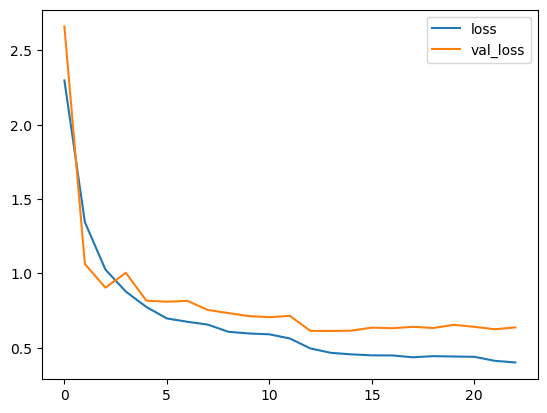

In [74]:
# Plotting training and validation loss
historyDf.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

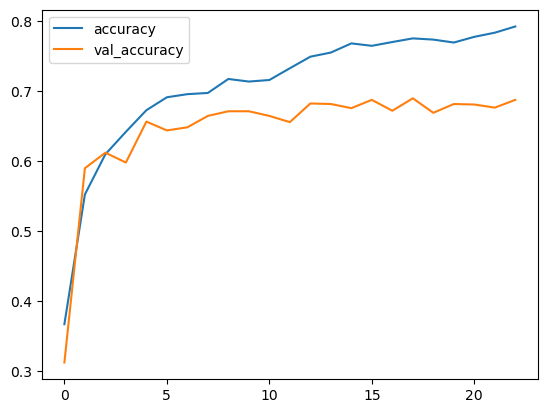

In [75]:
# Plotting training and validation accuracy
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

In [76]:
# Evaluating model
score = model.evaluate(testX, testY)[1] * 100
print(f'Validation accuracy of model : {score:.2f}%')

43/43 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6896
Validation accuracy of model : 68.96%


43/43 [==============================] - 2s 22ms/step


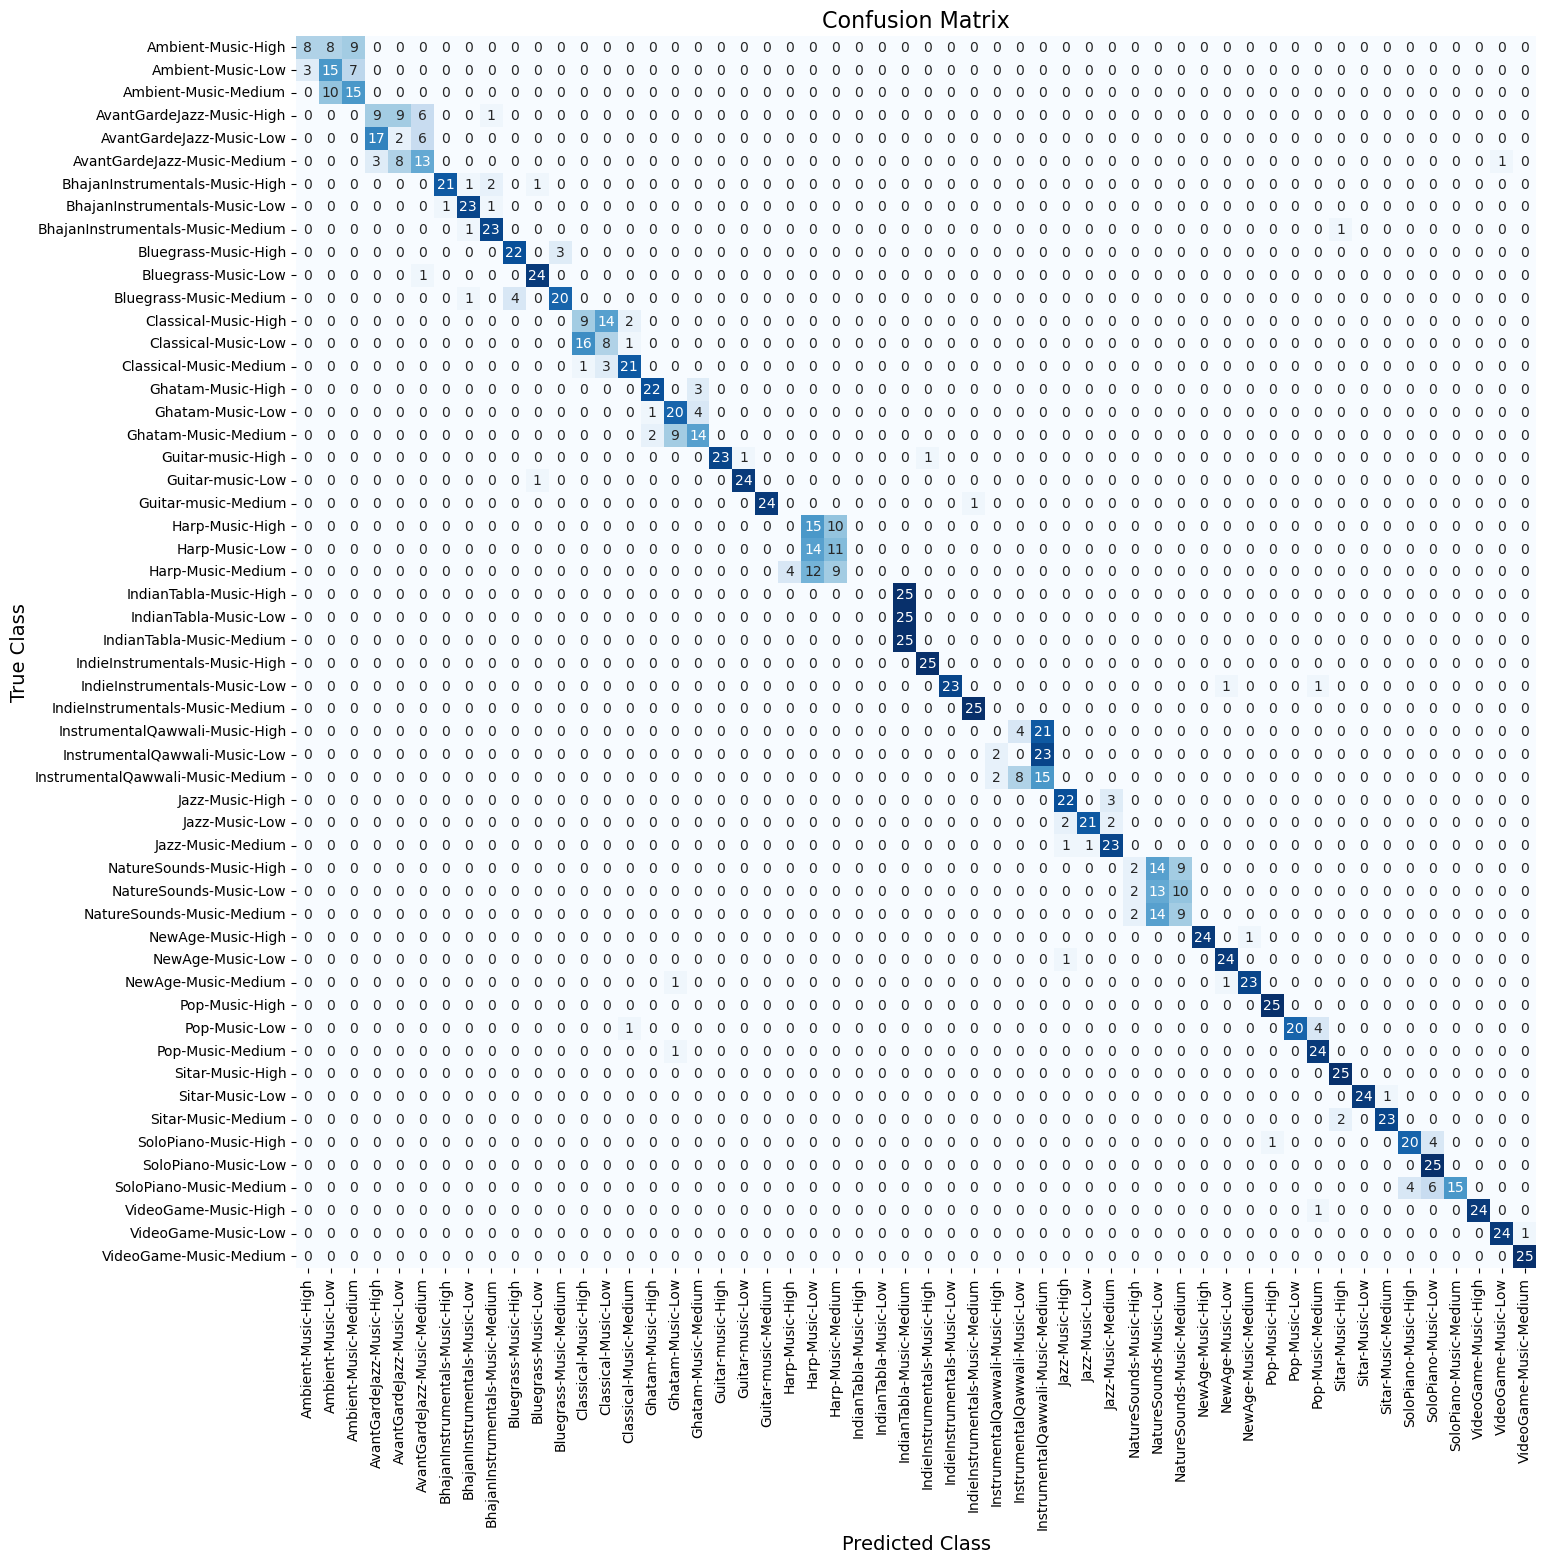

In [80]:
# Plotting confusion matrix
pred = np.argmax(model.predict(testX), axis = 1)
true = np.argmax(testY, axis = 1)

matrix = confusion_matrix(true, pred)

plt.figure(figsize = (16, 16))
sns.heatmap(matrix, annot = True, cbar = False, fmt = 'd', cmap = 'Blues', xticklabels = encoder.classes_, yticklabels = encoder.classes_)
plt.title('Confusion Matrix', fontsize = 16)
plt.xlabel('Predicted Class', fontsize = 14)
plt.xticks(rotation = 90)
plt.ylabel('True Class', fontsize = 14)
plt.show()

In [79]:
model.save('music_sound_identification_model.h5')